## Inteligență Artificială - Laboratorul 1 : Căutări
 - Tudor Berariu <tudor.berariu@gmail.com>
 - Andrei Olaru <cs@andreiolaru.ro>
 - Cătălin-Mihail Chiru <cata.chiru99@gmail.com>

### Scopul laboratorului

De foarte multe ori problemele care sunt legate de domeniul inteligenței artificiale sunt abstractizate ca o **căutare în spațiul stărilor** problemei. Laboratorul de astăzi își propune să prezinte un algoritm de căutare informată: **A\***.

### Problema

În cadrul acestui laborator vom rezolva 2 probleme:
* găsirea unui drum între două poziții pe o hartă bidimensională cu obstacole
* rezolvarea unui 8-puzzle

Problemele de căutare sunt în general abstractizate cu grafuri. Harta bidimensională poate fi văzută ca un graf neorientat în care fiecare nod corespunde unei celule de pe hartă, iar o muchie conectează nodurile corespunzătoare  unor celule adiacente.

Problema de tip 8-puzzle poate fi văzută ca un graf neorientat în care nodurile corespund posibilelor aranjări ale pieselor, iar muchiile conectează noduri între care se poate ajunge printr-o singură mutare legală.

#### Labirintul

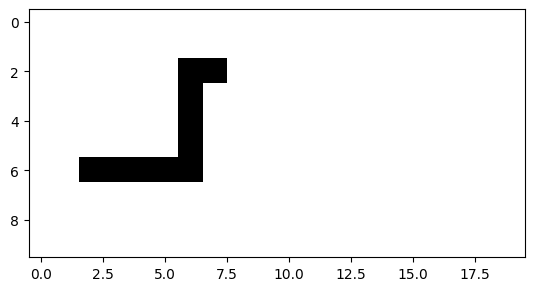

In [3]:
# Vom reprezenta labirintul printr-un tablou bidimensional (o listă de liste)
# celulele libere vor avea valoarea 0, iar pereții valoarea 1

height = 10
width = 20

# Construim labirintul ca o listă de liste
labyrinth = [[0 for c in range(width)] for r in range(height)]

# Așezăm câteva obstacole pe hartă
for r in range(2, 7):
    labyrinth[r][6] = 1
    labyrinth[6][r] = 1
labyrinth[2][7] = 1

%matplotlib inline
import matplotlib.pyplot as pyplot
pyplot.imshow(labyrinth, cmap='Greys', interpolation='nearest');

In [28]:
# Punctul de plecare și punctul destinație vor fi reprezentate prin tupluri
start = (5, 5)
final = (8, 8)

is_final_labyrinth = lambda position: position == final

list(map(is_final_labyrinth, [(1,1), (3, 6), (8, 8)]))

[False, False, True]

### Algoritmul A* pentru labirint

Pentru a implementa algoritmul **A\*** trebuie să putem construi vecinii valizi ai unei stări.

In [10]:
# Scrieți o funcție care verifică dacă un tuplu dat reprezintă
# coordonatele unei poziții libere de pe hartă (coordonatele nu depășesc limitele hărții
# și acolo nu se găsește un obstacol)

def is_good(pos):
    if pos[0] >= 0 and pos[0] < height and pos[1] >= 0 and pos[1] < width:
        if labyrinth[pos[0]][pos[1]] != 1:
            return True
    return False

[is_good(p) for p in [(-1,2), (height,3), (width,4), (5,5), (6,6)]] # False, False, False, True, False

[False, False, False, True, False]

In [11]:
# Scrieți o funcție care întoarce celulele vecine poziției date (doar cele libere)
# Vecinii se află la o distanță de o singură celulă pe orizontală sau verticală, fără diagonale.
# Folosiți funcționala filter și funcția is_good scrisă anterior

def get_neighbours_labyrinth(pos):
    lista = []
    listaVecini = [(pos[0]-1, pos[1]), (pos[0]+1, pos[1]), (pos[0], pos[1]-1), (pos[0], pos[1]+1)]
    lista = list(filter(lambda x: is_good(x), listaVecini))
    
    return lista


[get_neighbours_labyrinth(p) for p in [(0,9), (5,5)]] # ==> [[(1,9), (0,8), (0, 10)], [(4,5), (5,4)]] - nu neaparat în ordinea asta

[[(1, 9), (0, 8), (0, 10)], [(4, 5), (5, 4)]]

#### Funcții euristice

Implementați două funcții euristice pe care să le folosiți în algoritmul **A\***:
 - distanța euclidiană
 - distanța Manhattan

In [15]:
from math import sqrt

def euclidean_distance(a, b):
    return sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

euclidean_distance((2,3), (4, 7))   # ==> 4.4721359

4.47213595499958

In [49]:
def manhattan_distance_labyrinth(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

manhattan_distance_labyrinth((2,3), (4,0))  # ==> 5

5

#### Algoritmul A\*

Scrieți o funcție ce implementează algoritmul **A\***. Funcția va primi 3 argumente:
 - **start** - starea inițială
 - **end** - starea finală (necesară pentru apelul lui *h*
 - **h** - funcția euristică folosită
 - **neighbors** - funcția care obține vecinii unei stări
 - **is_final** - funcția care determină dacă o stare este finală
 - **print_state** - funcție pe care o puteți folosi pentru a afișa o stare
 
Frontiera va fi o coadă de priorități ce va conține nodurile descoperite:
 - prioritatea va fi dată de funcția de cost **f** (cost real din nodul de start + valoare estimată până la nodul final)

Pentru informațiile ce trebuie memorate pentru fiecare nod descoperit vom folosi un dicționar în care reținem pentru  fiecare stare părintele și costul **g** de la starea inițială până la starea respectivă:

    disovered[node] = (parent, cost_g)
    

#### Cozi de priorități

Pentru coada de priorități necesară algoritmului **A\*** vom folosi heap-ul din Python [[1]](https://docs.python.org/3/library/heapq.html).

In [17]:
from heapq import heappop, heappush

priority_queue = []
heappush(priority_queue, (2, 'A'))
heappush(priority_queue, (1, 'B'))
heappush(priority_queue, (1.5, 'C'))

print(heappop(priority_queue))  # ==> (1, 'B')
print(heappop(priority_queue))  # ==> (1.5, 'C')
print(heappop(priority_queue))  # ==> (2, 'A')

(1, 'B')
(1.5, 'C')
(2, 'A')


In [18]:
def print_state_labyrinth(discovered, results):
    cost_map = [[discovered[(r,c)][1] if (r,c) in discovered else 0 for c in range(width)]for r in range(height)]
    pyplot.imshow(cost_map , cmap='Greys', interpolation='nearest')
    pyplot.show()
    print(results)


In [74]:
def astar(start, end, h, neighbours, is_final, print_state, print_flag=True):
    # Frontiera, ca listă (heap) de tupluri (cost_f, nod)
    frontier = []
    heappush(frontier, (0 + h(start, end), start))
    
    # Nodurile descoperite ca dicționar nod -> (părinte, cost_g-până-la-nod)
    discovered = {start: (None, 0)}

    # Implementăm algoritmul A*
    while frontier:
        element = heappop(frontier)
        if is_final(element[1]):
            break
        
        vecini = neighbours(element[1])
        
        for vecin in vecini:
            cost = element[0] + 1 - h(element[1], end)
            if vecin not in discovered:
                    discovered[vecin] = (element, cost)
                    heappush(frontier, (cost + h(vecin, end) , vecin))
            elif discovered[vecin][1] > cost:
                discovered[vecin] = (element, cost)
                heappush(frontier, (cost + h(vecin, end) , vecin))
        
    # Refacem drumul de la final la start folosindu-ne de dicționarul discovered
    path = []
    last_node = end

    # TODO
    while last_node in discovered:
        path.append(last_node)
        last_node = discovered[last_node][0]

    # TODO
    results = reversed(path)

    if print_flag:
        print_state(discovered, results)
    
    return results, len(discovered.keys()) # drumul, ca listă de poziții, și numărul de stări descoperite

Pentru a ilustra influența funcției euristice asupra eficienței algorithmului **A\***, vom păstra într-un dicționar numărul de noduri expandate pentru fiecare funcție euristică:

In [34]:
heuristic_metrics_labyrinth = {}

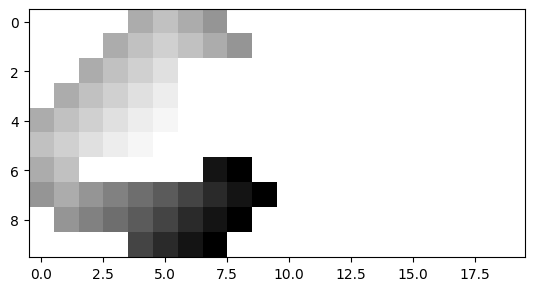

In [75]:
heuristic_metrics_labyrinth['euclidean'] =  astar(start, final, euclidean_distance, get_neighbours_labyrinth, is_final_labyrinth, print_state_labyrinth)

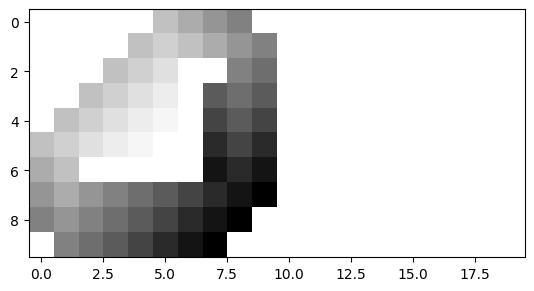

In [50]:
heuristic_metrics_labyrinth['manhattan'] =  astar(start, final, manhattan_distance_labyrinth, get_neighbours_labyrinth, is_final_labyrinth, print_state_labyrinth)

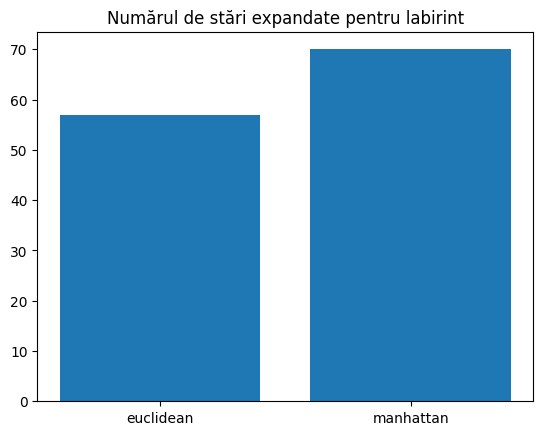

In [51]:
def barplot_number_of_expanded_nodes(heuristic_metrics, task_name):
    plot_metrics = [(key, value[1]) for key, value in heuristic_metrics.items()]
    plot_metrics.sort(key=lambda x: x[1])

    names = [x[0] for x in plot_metrics]
    values = [x[1] for x in plot_metrics]

    pyplot.bar(range(len(names)), values, align='center')
    pyplot.xticks(range(len(names)), names)
    pyplot.title(f'Numărul de stări expandate pentru {task_name}')
    pyplot.show()
barplot_number_of_expanded_nodes(heuristic_metrics_labyrinth, 'labirint')
# Observăm că distanța Manhattan este mai eficientă decât distanța euclidiană, pentru explorarea labirintului.

### A-star pentru un joc de tip 8-puzzle

Propunem rezolvarea jocului $n^2 - 1$ tiles folosind algoritmul A*.

Want to [know](https://en.wikipedia.org/wiki/15_Puzzle) [more](https://github.com/jussihyva/n-puzzle/blob/master/README.md)

In [53]:
import numpy as np

Ne vom folosi de matplotlib pentru a afișa starea curentă a jocului, sub forma unei imagini.

In [54]:
no_tiles = 8

In [55]:
img = pyplot.imread('eminescu.jpg')
img = np.array(img)
img.shape # dimensiunea și numărul de canale de culoare

(1126, 800, 3)

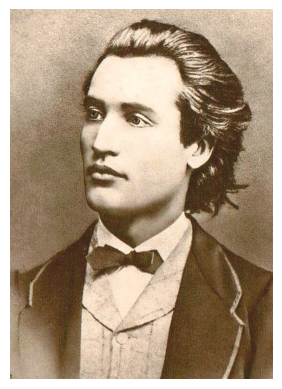

In [56]:
pyplot.imshow(img)
pyplot.axis('off')
pyplot.show()

3 tiles


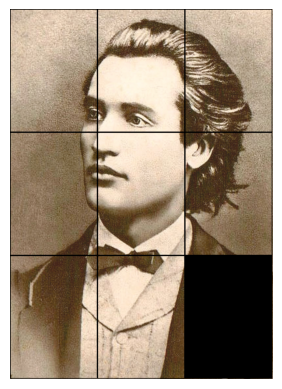

In [57]:
def create_borders(image, thickness, start_height, end_height, start_width, end_width):
    # Desenam chenarul fiecarui tile
    image[start_height:start_height + thickness, start_width:end_width] = 0
    image[end_height - thickness:end_height, start_width:end_width] = 0

    image[start_height:end_height, start_width:start_width + thickness] = 0
    image[start_height:end_height, end_width - thickness:end_width] = 0

    return image

# Vom împărți imaginea în n^2 părți egale și vom face ultimul pătrat negru
def break_image_into_tiles(image, no_tiles, thickness=2):
    tiles = []
    tile_size = np.sqrt(no_tiles + 1).astype(int)
    print(tile_size, "tiles")
    i = 0
    tile_height, max_height = image.shape[0] // tile_size, image.shape[0] - 1
    tile_width, max_width = image.shape[1] // tile_size, image.shape[1] - 1

    for r in range(tile_size):
        for c in range(tile_size):
            # Border around each tile
            start_height, end_height = r * tile_height, min((r + 1) * tile_height, max_height)
            start_width, end_width = c * tile_width, min((c + 1) * tile_width, max_width)

            image = create_borders(image, thickness, start_height, end_height, start_width, end_width)
            
            tiles.append(image[start_height:end_height, start_width:end_width])

            # Eliminam chenarul pentru tile-ul final
            if i == no_tiles:
                image[start_height:end_height, start_width:end_width] = 0
                break
            i += 1

    return tiles, image

tiles, image = break_image_into_tiles(img, no_tiles)
pyplot.imshow(img)
pyplot.axis('off')
pyplot.show()

Miscari posibile:
1. Jos (Spațiul gol se mută în sus)
2. Sus (Spațiul gol se mută în jos)
3. Dreapta (Spațiul gol se mută în stânga)
4. Stânga (Spațiul gol se mută în dreapta)

In [58]:
UP, DOWN, LEFT, RIGHT = 1, 2, 3, 4
debugging_mutari_celula_goala = {UP: 'sus', DOWN: 'jos', LEFT: 'stanga', RIGHT: 'dreapta'}

* Vom folosi în logica internă a puzzle-ului n-tiles o reprezentare a stării sub forma unei matrici de dimensiune n x n, în care fiecare element reprezintă o piesă a puzzle-ului. Spațiul gol va fi reprezentat de valoarea n^2 - 1.

* Ne folosim de biblioteca numpy pentru a manipula matricile mai ușor.

* Vom expune starea curentă a jocului sub forma unui tuplu. Avem nevoie de serializarea stării pentru a o putea folosi în dicționarul de descoperiri și în coada de priorități.

* Pentru a printa evoluția puzzle-ului, vom mapa tuplul/matricea stării curente peste imaginea inițială a puzzle-ului.

In [60]:
final_state_ntiles = tuple(range(no_tiles + 1))

In [61]:
def serialize_state(state):
    return tuple(state.flatten())

def deserialize_state(serialized_state):
    size = int(np.sqrt(len(serialized_state)))
    deserialize_state = np.array(serialized_state)
    return deserialize_state.reshape(size, size)

serialize_state(deserialize_state(final_state_ntiles))

(0, 1, 2, 3, 4, 5, 6, 7, 8)

In [62]:
initial_state = serialize_state(np.array([[2, 4, 3], [5, 8, 6], [7, 1, 0]]))

In [63]:
# O stare a jocului va fi reprezentată de o matrice (parsată ca tuplu) de dimensiune n x n
# Mișcările posibile indică direcția în care se poate deplasa spațiul gol
def valid_moves(state):
    inner_state = deserialize_state(state)
    no_tiles = len(state) - 1

    row, col = np.where(inner_state == no_tiles)
    
    height, width = inner_state.shape
    # print(row, col)
    row, col = row[0], col[0]
    moves = []

    if row > 0: moves.append(UP)
    if row < height - 1: moves.append(DOWN)
    if col > 0: moves.append(LEFT)
    if col < width - 1: moves.append(RIGHT)
    return moves

valid_moves(serialize_state((np.array([[0, 1, 2], [3, 7, 4], [6, 8, 5]])))) # ==> [1, 3, 4]

[1, 3, 4]

In [64]:
state = np.array([[0, 1, 2], [3, 7, 4], [6, 8, 5]])

# Mișcă spațiu gol în direcția specificată
def apply_move(state, move):
    inner_state = deserialize_state(state)
    no_tiles = len(state) - 1

    row, col = np.where(inner_state == no_tiles)
    row, col = row[0], col[0]
    if move == UP: inner_state[row, col], inner_state[row - 1, col] = inner_state[row - 1, col], inner_state[row, col]
    elif move == DOWN: inner_state[row, col], inner_state[row + 1, col] = inner_state[row + 1, col], inner_state[row, col]
    elif move == LEFT: inner_state[row, col], inner_state[row, col - 1] = inner_state[row, col - 1], inner_state[row, col]
    elif move == RIGHT: inner_state[row, col], inner_state[row, col + 1] = inner_state[row, col + 1], inner_state[row, col]
    return serialize_state(inner_state)

apply_move(serialize_state(state), 1)  # ==> (0, 1, 2, 3, 8, 4, 6, 7, 5)

(0, 1, 2, 3, 8, 4, 6, 7, 5)

In [65]:
def get_neighbours_ntiles(state):
    return [apply_move(state, move) for move in valid_moves(state)]

get_neighbours_ntiles(serialize_state(state)) # ==> [(0, 1, 2, 3, 8, 4, 6, 7, 5), (0, 1, 2, 3, 7, 4, 8, 6, 5),  (0, 1, 2, 3, 7, 4, 6, 5, 8)]

[(0, 1, 2, 3, 8, 4, 6, 7, 5),
 (0, 1, 2, 3, 7, 4, 8, 6, 5),
 (0, 1, 2, 3, 7, 4, 6, 5, 8)]

In [66]:
def generate_valid_shuffle(state, no_moves, seed=0):

    np.random.seed(seed)

    complementary_moves = {1: 2, 2: 1, 3: 4, 4: 3}

    possible_moves = valid_moves(state)

    # print(list(map(lambda x: debugging_mutari_celula_goala[x], possible_moves)))

    picked_move = np.random.choice(possible_moves, 1)[0]

    apply_move(state, picked_move)

    for i in range(no_moves - 1):
        # Evităm mutările care ar anula mutarea anterioară
        complementary_move = complementary_moves[picked_move]
        possible_moves = valid_moves(state)
        possible_moves = list(filter(lambda x: x != complementary_move, possible_moves))

        picked_move = np.random.choice(possible_moves, 1)[0]

        # Aplicăm mutarea
        state = apply_move(state, picked_move)

    return state

state = generate_valid_shuffle(serialize_state(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])), 1000)
state

(5, 8, 2, 3, 6, 1, 0, 7, 4)

In [67]:
def is_final_ntiles(state):
    size = len(state)
    gt = tuple(range(size))
    return state == gt

is_final_ntiles(serialize_state(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])))  # ==> True

True

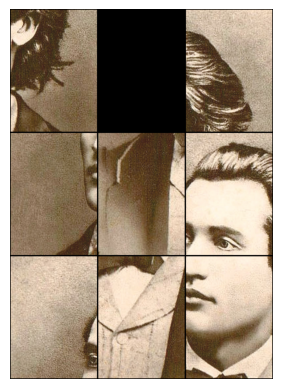

In [68]:
def print_tiles(state, tiles):
    size = int(np.sqrt(len(state)))
    new_image = np.zeros((size * tiles[0].shape[0], size * tiles[0].shape[1], 3), dtype=np.uint8)

    for r in range(size):
        for c in range(size):
            tile = tiles[state[r * size + c]]
            new_image[r * tile.shape[0]:(r + 1) * tile.shape[0], c * tile.shape[1]:(c + 1) * tile.shape[1]] = tile

    pyplot.axis('off')
    pyplot.imshow(new_image)
    pyplot.show()
    return new_image

def print_state_ntiles(tiles):
    def actual_print(_, results):
        for state in results: print_tiles(state, tiles)
    return actual_print

new_img = print_tiles(state, tiles)

# Funcții euristice

In [69]:
def manhattan_distance_ntiles(state_position, final_position):
    inner_state = deserialize_state(state_position)
    inner_final = deserialize_state(final_position)
    
    size = inner_state.shape[0]
    max_length = size * size
    distance = 0

    for i in range(max_length):
        state_row, state_col = np.where(inner_state == i)
        final_row, final_col = np.where(inner_final == i)

        state_row, state_col = state_row[0], state_col[0]
        final_row, final_col = final_row[0], final_col[0]

        distance += abs(state_row - final_row) + abs(state_col - final_col)

    return distance

def absolute_distance_ntiles(state, final):
    return np.sum(np.abs(deserialize_state(state) - deserialize_state(final)))

# manhattan_distance_ntiles(state, tuple(range(no_tiles + 1)))
# absolute_distance_ntiles(state, final_state)

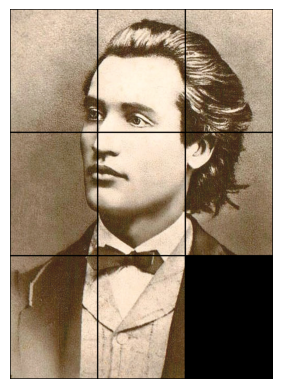

In [70]:
results_manhattan = astar(state, tuple(range(no_tiles + 1)), manhattan_distance_ntiles, get_neighbours_ntiles, is_final_ntiles, print_state_ntiles(tiles))

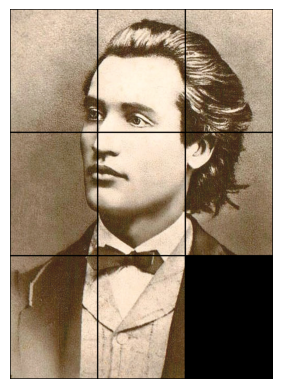

In [71]:
results_absolute =  astar(state, tuple(range(no_tiles + 1)), absolute_distance_ntiles, get_neighbours_ntiles, is_final_ntiles, print_state_ntiles(tiles))

In [73]:
# Pe baza testarii unui număr redus de stări inițiale, vedem că nu există o diferență semnificativă între cele două euristici.
# Rulăm pentru un număr mai mare de stări inițiale pentru a observa diferențele.

def strip_name_from_anon_heuristic(name):
    return str(name).split(' ')[1].split('_')[0]

def run_multiple_states(final_state_ntiles, heuristics, neighbours, is_final, print_state, no_games):
    metrics_per_heuristic = {strip_name_from_anon_heuristic(h) : (h, []) for h in heuristics}

    # Generăm seedurile pentru stările inițiale
    seeds = np.arange(no_games * 100)

    np.random.shuffle(seeds)
    seeds = seeds[:no_games]

    for (i, seed) in enumerate(seeds):
        print(f"Running game {i + 1} out of {no_games}")

        state = generate_valid_shuffle(final_state_ntiles, 1000, seed)
        for h_name in metrics_per_heuristic:
            h, results = metrics_per_heuristic[h_name]
            results.append(astar(state, final_state_ntiles, h, neighbours, is_final, print_state, False)[1])

    metrics_per_heuristic = {name: (name, np.mean(results)) for name, (_, results) in metrics_per_heuristic.items()}

    return metrics_per_heuristic



Running game 1 out of 50
Running game 2 out of 50
Running game 3 out of 50
Running game 4 out of 50
Running game 5 out of 50
Running game 6 out of 50
Running game 7 out of 50
Running game 8 out of 50
Running game 9 out of 50
Running game 10 out of 50
Running game 11 out of 50
Running game 12 out of 50
Running game 13 out of 50
Running game 14 out of 50
Running game 15 out of 50
Running game 16 out of 50
Running game 17 out of 50
Running game 18 out of 50
Running game 19 out of 50
Running game 20 out of 50
Running game 21 out of 50
Running game 22 out of 50
Running game 23 out of 50
Running game 24 out of 50
Running game 25 out of 50
Running game 26 out of 50
Running game 27 out of 50
Running game 28 out of 50
Running game 29 out of 50
Running game 30 out of 50
Running game 31 out of 50
Running game 32 out of 50
Running game 33 out of 50
Running game 34 out of 50
Running game 35 out of 50
Running game 36 out of 50
Running game 37 out of 50
Running game 38 out of 50
Running game 39 out o

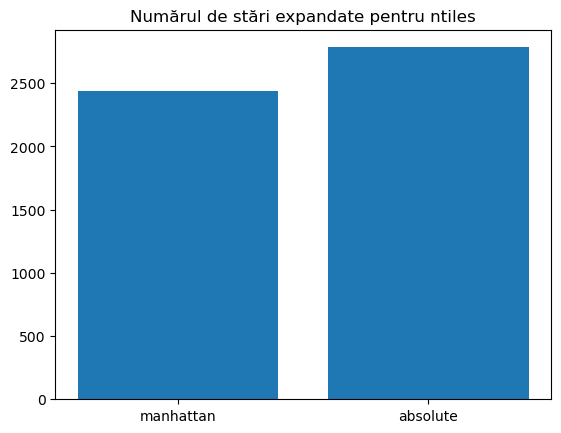

In [35]:
# Rulați pentru 50 de stări inițiale
# Pe baza barplot-ului generat, ar trebui să observați că distanța Manhattan este mai eficientă decât distanța absolută din perspectiva numărului de stări expandate.
heuristic_metrics_ntiles_50games = run_multiple_states(final_state_ntiles, [manhattan_distance_ntiles, absolute_distance_ntiles], get_neighbours_ntiles, is_final_ntiles, print_state_ntiles(tiles), 50)

print("Results for 50 games: ", *list(heuristic_metrics_ntiles_50games.values()))

barplot_number_of_expanded_nodes(heuristic_metrics_ntiles_50games, 'ntiles')

Running game 1 out of 100
Running game 2 out of 100
Running game 3 out of 100
Running game 4 out of 100
Running game 5 out of 100
Running game 6 out of 100
Running game 7 out of 100
Running game 8 out of 100
Running game 9 out of 100
Running game 10 out of 100
Running game 11 out of 100
Running game 12 out of 100
Running game 13 out of 100
Running game 14 out of 100
Running game 15 out of 100
Running game 16 out of 100
Running game 17 out of 100
Running game 18 out of 100
Running game 19 out of 100
Running game 20 out of 100
Running game 21 out of 100
Running game 22 out of 100
Running game 23 out of 100
Running game 24 out of 100
Running game 25 out of 100
Running game 26 out of 100
Running game 27 out of 100
Running game 28 out of 100
Running game 29 out of 100
Running game 30 out of 100
Running game 31 out of 100
Running game 32 out of 100
Running game 33 out of 100
Running game 34 out of 100
Running game 35 out of 100
Running game 36 out of 100
Running game 37 out of 100
Running ga

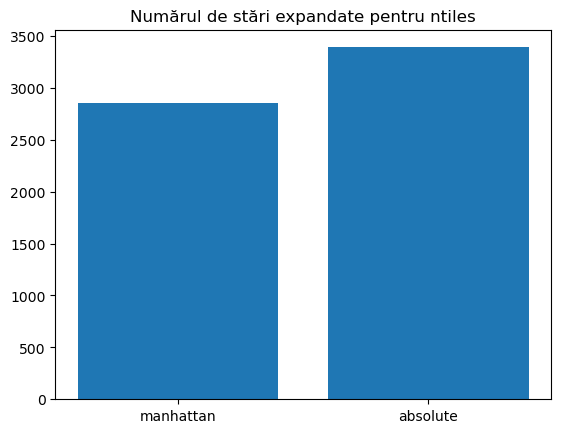

In [97]:
# heuristic_metrics_ntiles_100games1 = run_multiple_states(final_state_ntiles, [manhattan_distance_ntiles, absolute_distance_ntiles], get_neighbours_ntiles, is_final_ntiles, print_state_ntiles(tiles), 100)

# print("Results for 100 games: ", *list(heuristic_metrics_ntiles_100games1.values()))

# barplot_number_of_expanded_nodes(heuristic_metrics_ntiles_100games1, 'ntiles')

Running game 1 out of 100
Running game 2 out of 100
Running game 3 out of 100
Running game 4 out of 100
Running game 5 out of 100
Running game 6 out of 100
Running game 7 out of 100
Running game 8 out of 100
Running game 9 out of 100
Running game 10 out of 100
Running game 11 out of 100
Running game 12 out of 100
Running game 13 out of 100
Running game 14 out of 100
Running game 15 out of 100
Running game 16 out of 100
Running game 17 out of 100
Running game 18 out of 100
Running game 19 out of 100
Running game 20 out of 100
Running game 21 out of 100
Running game 22 out of 100
Running game 23 out of 100
Running game 24 out of 100
Running game 25 out of 100
Running game 26 out of 100
Running game 27 out of 100
Running game 28 out of 100
Running game 29 out of 100
Running game 30 out of 100
Running game 31 out of 100
Running game 32 out of 100
Running game 33 out of 100
Running game 34 out of 100
Running game 35 out of 100
Running game 36 out of 100
Running game 37 out of 100
Running ga

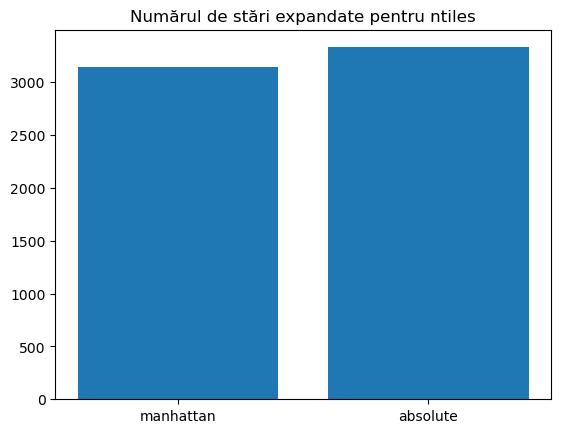

In [98]:
# heuristic_metrics_ntiles_100games2 = run_multiple_states(final_state_ntiles, [manhattan_distance_ntiles, absolute_distance_ntiles], get_neighbours_ntiles, is_final_ntiles, print_state_ntiles(tiles), 100)

# print("Results for 100 games: ", *list(heuristic_metrics_ntiles_100games2.values()))

# barplot_number_of_expanded_nodes(heuristic_metrics_ntiles_100games2, 'ntiles')

Running game 1 out of 1000
Running game 2 out of 1000
Running game 3 out of 1000
Running game 4 out of 1000
Running game 5 out of 1000
Running game 6 out of 1000
Running game 7 out of 1000
Running game 8 out of 1000
Running game 9 out of 1000
Running game 10 out of 1000
Running game 11 out of 1000
Running game 12 out of 1000
Running game 13 out of 1000
Running game 14 out of 1000
Running game 15 out of 1000
Running game 16 out of 1000
Running game 17 out of 1000
Running game 18 out of 1000
Running game 19 out of 1000
Running game 20 out of 1000
Running game 21 out of 1000
Running game 22 out of 1000
Running game 23 out of 1000
Running game 24 out of 1000
Running game 25 out of 1000
Running game 26 out of 1000
Running game 27 out of 1000
Running game 28 out of 1000
Running game 29 out of 1000
Running game 30 out of 1000
Running game 31 out of 1000
Running game 32 out of 1000
Running game 33 out of 1000
Running game 34 out of 1000
Running game 35 out of 1000
Running game 36 out of 1000
R

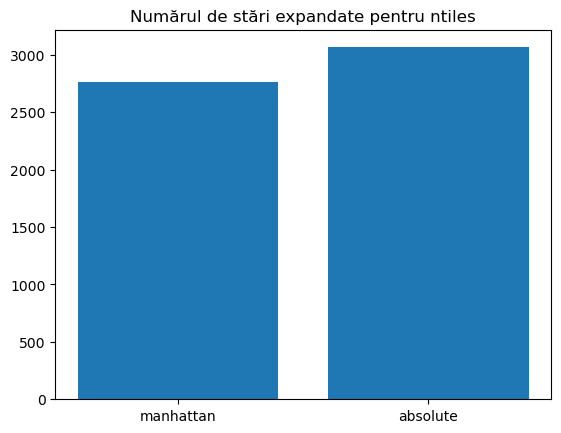

In [99]:
# heuristic_metrics_ntiles_1000games = run_multiple_states(final_state_ntiles, [manhattan_distance_ntiles, absolute_distance_ntiles], get_neighbours_ntiles, is_final_ntiles, print_state_ntiles(tiles), 1000)

# print("Results for 1000 games: ", *list(heuristic_metrics_ntiles_1000games.values()))

# barplot_number_of_expanded_nodes(heuristic_metrics_ntiles_1000games, 'ntiles')

Running game 1 out of 1000
Running game 2 out of 1000
Running game 3 out of 1000
Running game 4 out of 1000
Running game 5 out of 1000
Running game 6 out of 1000
Running game 7 out of 1000
Running game 8 out of 1000
Running game 9 out of 1000
Running game 10 out of 1000
Running game 11 out of 1000
Running game 12 out of 1000
Running game 13 out of 1000
Running game 14 out of 1000
Running game 15 out of 1000
Running game 16 out of 1000
Running game 17 out of 1000
Running game 18 out of 1000
Running game 19 out of 1000
Running game 20 out of 1000
Running game 21 out of 1000
Running game 22 out of 1000
Running game 23 out of 1000
Running game 24 out of 1000
Running game 25 out of 1000
Running game 26 out of 1000
Running game 27 out of 1000
Running game 28 out of 1000
Running game 29 out of 1000
Running game 30 out of 1000
Running game 31 out of 1000
Running game 32 out of 1000
Running game 33 out of 1000
Running game 34 out of 1000
Running game 35 out of 1000
Running game 36 out of 1000
R

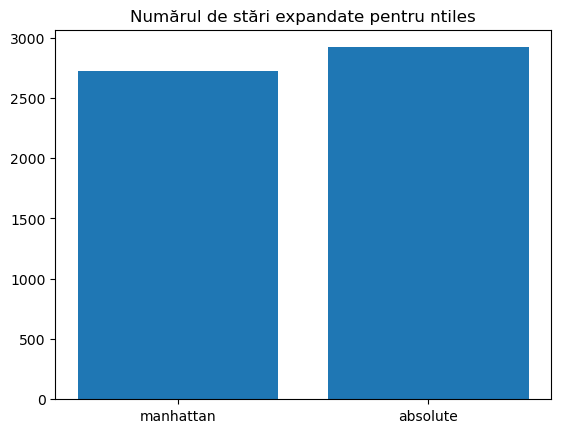

In [100]:
# heuristic_metrics_ntiles_1000games2 = run_multiple_states(final_state_ntiles, [manhattan_distance_ntiles, absolute_distance_ntiles], get_neighbours_ntiles, is_final_ntiles, print_state_ntiles(tiles), 1000)

# print("Results for 1000 games: ", *list(heuristic_metrics_ntiles_1000games2.values()))

# barplot_number_of_expanded_nodes(heuristic_metrics_ntiles_1000games2, 'ntiles')